In [1]:
pip install xgboost scikit-learn matplotlib seaborn
pip install lightgbm

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.1/150.0 MB 16.8 MB/s eta 0:00:09
   - -------------------------------------- 6.0/150.0 MB 15.4 MB/s eta 0:00:10
   -- ------------------------------------- 9.4/150.0 MB 15.5 MB/s eta 0:00:10
   --- ------------------------------------ 12.8/150.0 MB 15.8 MB/s eta 0:00:09
   ---- ----------------------------------- 16.0/150.0 MB 15.5 MB/s eta 0:00:09
   ----- ---------------------------------- 19.4/150.0 MB 15.7 MB/s eta 0:00:09
   ------ --------------------------------- 22.5/150.0 MB 15.7 MB/s eta 0:00:09
   ------ --------------------------------- 25.7/150.0 MB 15.5 MB/s eta 0:00:09
   ------- -------------------------------- 28.8/150.0 MB 15.5 MB/s eta 0:00:08
   -------- ------------------------------- 32.2/150.0 MB 15.5 MB/s eta 0:00:08
   --------- ------------------------------ 35.4/150.0 MB 15.6 MB/s eta 0:00:08
   ---------- ----------------------------- 38.5/150

In [1]:
# Credit Risk Model Training: Logistic Regression vs XGBoost

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load Cleaned Dataset
df = pd.read_csv("../data/processed/cleaned_credit_data.csv")

print("Loaded dataset:", df.shape)
df.head()

Loaded dataset: (29564, 34)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,default payment next month,log_limit_bal,avg_pay_status,std_pay_status,max_pay_status,avg_bill_amt,std_bill_amt,max_bill_amt,avg_pay_amt,std_pay_amt
0,1,20000,2,2,1,24,2,2,-1,-1,...,1,9.903538,-0.333333,1.861899,2,1284.000000,1761.633219,3913,114.833333,281.283072
1,2,120000,2,2,2,26,-1,2,0,0,...,1,11.695255,0.500000,1.224745,2,2846.166667,637.967841,3455,833.333333,752.772653
2,3,90000,2,2,2,34,0,0,0,0,...,0,11.407576,0.000000,0.000000,0,16942.166667,6064.518593,29239,1836.333333,1569.815488
3,4,50000,2,2,1,37,0,0,0,0,...,0,10.819798,0.000000,0.000000,0,38555.666667,10565.793518,49291,1398.000000,478.058155
4,5,50000,1,2,1,57,-1,0,-1,0,...,0,10.819798,-0.333333,0.516398,0,18223.166667,10668.590074,35835,9841.500000,13786.230736


In [2]:
# Define Features and Target
X = df.drop(columns=["default payment next month"])
y = df["default payment next month"]

In [3]:
# Train/Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

Train shape: (23651, 33) | Test shape: (5913, 33)


In [4]:
# Logistic Regression (with StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:, 1]

In [5]:
# XGBoost Classifier
# Use scale_pos_weight = (non-defaults / defaults) for imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

C:\Users\arshc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [6]:
# Evaluation Function

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f" {name} Classification Report")
    print(classification_report(y_true, y_pred))

    print(f" ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

 Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      4604
           1       0.41      0.65      0.51      1309

    accuracy                           0.72      5913
   macro avg       0.65      0.69      0.65      5913
weighted avg       0.78      0.72      0.74      5913

 ROC AUC: 0.7445


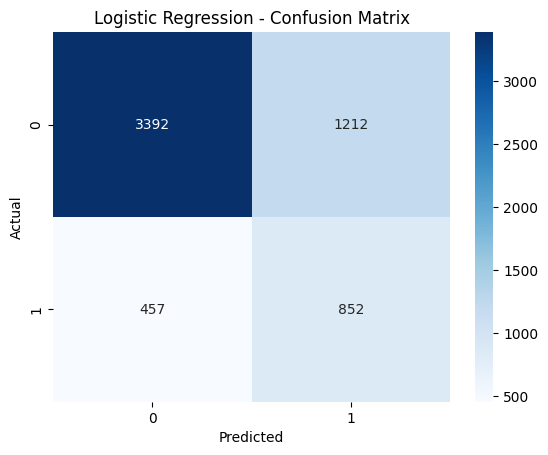

 XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4604
           1       0.46      0.57      0.51      1309

    accuracy                           0.76      5913
   macro avg       0.67      0.69      0.68      5913
weighted avg       0.78      0.76      0.77      5913

 ROC AUC: 0.7503


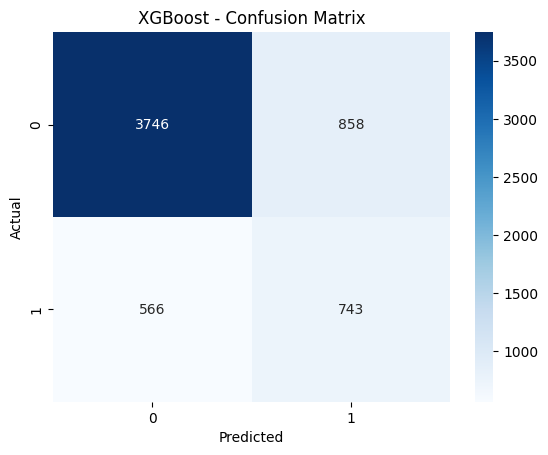

In [7]:
# Evaluate both models
evaluate_model("Logistic Regression", y_test, y_pred_log, y_prob_log)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob_xgb)

In [8]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Recalculate scale_pos_weight for LightGBM (same as XGBoost)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# LightGBM Classifier
lgbm = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

lgbm.fit(X_train, y_train)

# Predictions
y_pred_lgbm = lgbm.predict(X_test)
y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 5235, number of negative: 18416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4925
[LightGBM] [Info] Number of data points in the train set: 23651, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221344 -> initscore=-1.257853
[LightGBM] [Info] Start training from score -1.257853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

 LightGBM Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4604
           1       0.46      0.62      0.53      1309

    accuracy                           0.75      5913
   macro avg       0.67      0.71      0.68      5913
weighted avg       0.79      0.75      0.77      5913

 ROC AUC: 0.7768


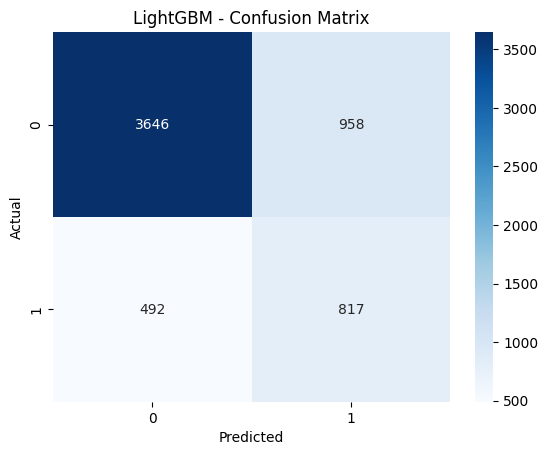

In [9]:
evaluate_model("LightGBM", y_test, y_pred_lgbm, y_prob_lgbm)

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'num_leaves': [31, 63],
    'scale_pos_weight': [scale_pos_weight]
}

In [12]:
lgbm = LGBMClassifier(random_state=42)

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1',
    cv=3,                   # 3-fold cross-validation
    verbose=1,
    n_jobs=-1               # Use all cores
)

In [13]:
grid.fit(X_train, y_train)

# Best model
best_lgbm = grid.best_estimator_
print("✅ Best Parameters Found:")
print(grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 5235, number of negative: 18416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4925
[LightGBM] [Info] Number of data points in the train set: 23651, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221344 -> initscore=-1.257853
[LightGBM] [Info] Start training from score -1.257853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

 LightGBM (Tuned) Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4604
           1       0.46      0.63      0.53      1309

    accuracy                           0.75      5913
   macro avg       0.67      0.71      0.68      5913
weighted avg       0.79      0.75      0.77      5913

 ROC AUC: 0.7790


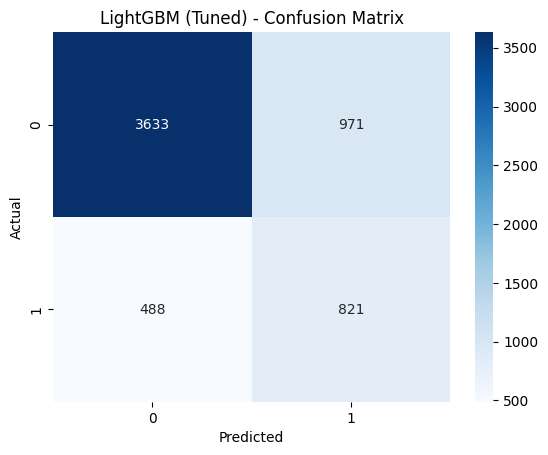

In [14]:
y_pred_lgbm_tuned = best_lgbm.predict(X_test)
y_prob_lgbm_tuned = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluate
evaluate_model("LightGBM (Tuned)", y_test, y_pred_lgbm_tuned, y_prob_lgbm_tuned)

In [29]:
pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 23.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----------- ---------------------------- 8.4/30.3 MB 47.2 MB/s eta 0:00:01
   -------------------- ------------------- 15.2/30.3 MB 36.7 MB/s eta 0:00:01
   --------------------------- ------------ 21.0/30.3 MB 33.1 MB/s eta 0:00:01
   ---------------------------------- ----- 26.5/30.3 MB 31.6 MB/s eta 0:00:01
   ---------------------------------------  30.1/30.3 MB 31.9 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 27.5 MB/s eta 0:00:00

   ----- ---------------------------------- 1/7 [tqdm]
   ----- ---------------------------------- 1/7 [tqdm]
   ----- ---------------------------------- 1/7 

In [15]:
import shap

explainer = shap.Explainer(best_lgbm, X_test)
shap_values = explainer(X_test)

C:\Users\arshc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|===================| 5866/5913 [00:34<00:00]        

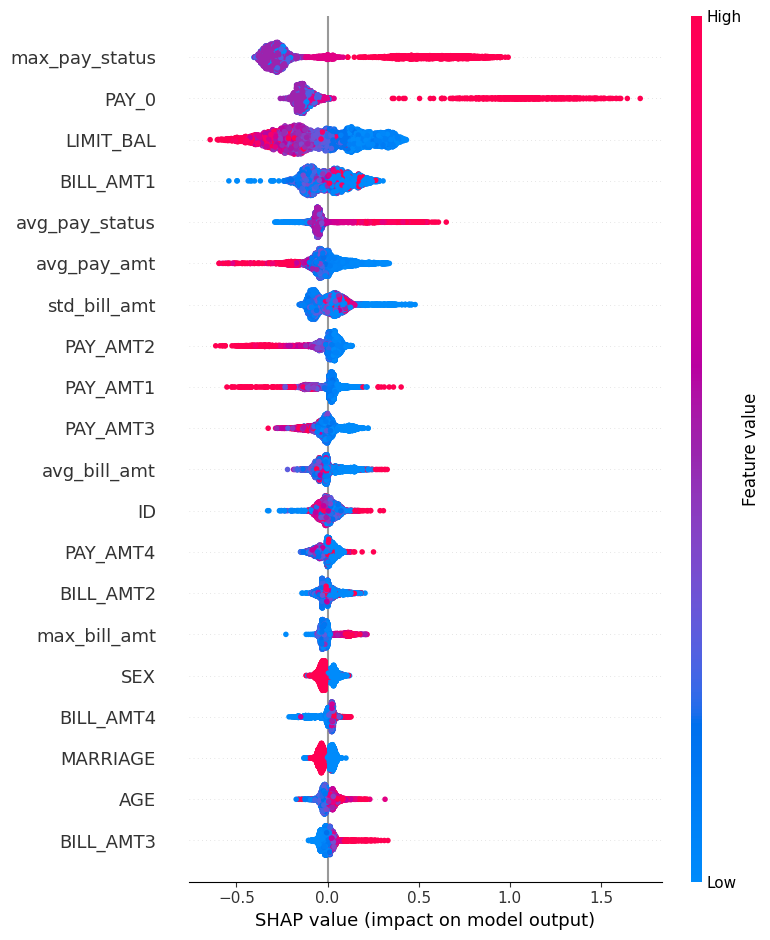

In [16]:
shap.summary_plot(shap_values.values, X_test)

In [17]:
# Sample Index
i = 51
sample = X_test.iloc[i:i+1]  # DataFrame format for SHAP

# Predict probability and score
prob_default = best_lgbm.predict_proba(sample)[0][1]
risk_score = int((1 - prob_default) * 1000)  # Scale: 0 = high risk, 1000 = low risk

print(f"Predicted default probability: {prob_default:.2f}")
print(f"Credit Risk Score (0–1000): {risk_score}")

Predicted default probability: 0.09
Credit Risk Score (0–1000): 905


In [16]:
print(sample.T)  # transposed for easier reading

                        18699
ID               18972.000000
LIMIT_BAL       210000.000000
SEX                  2.000000
EDUCATION            1.000000
MARRIAGE             2.000000
AGE                 28.000000
PAY_0                0.000000
PAY_2               -1.000000
PAY_3                0.000000
PAY_4                0.000000
PAY_5               -1.000000
PAY_6                0.000000
BILL_AMT1         9918.000000
BILL_AMT2         6942.000000
BILL_AMT3        24680.000000
BILL_AMT4        41291.000000
BILL_AMT5        10623.000000
BILL_AMT6        10765.000000
PAY_AMT1          6942.000000
PAY_AMT2         24000.000000
PAY_AMT3         22000.000000
PAY_AMT4         20000.000000
PAY_AMT5          5000.000000
PAY_AMT6          3000.000000
log_limit_bal       12.254868
avg_pay_status      -0.333333
std_pay_status       0.516398
max_pay_status       0.000000
avg_bill_amt     17369.833333
std_bill_amt     13259.516302
max_bill_amt     41291.000000
avg_pay_amt      13490.333333
std_pay_am

In [18]:
# SHAP explanation
explainer = shap.Explainer(best_lgbm, X_test)
shap_values = explainer(X_test)

# Get feature impact for this instance
impact_df = pd.DataFrame({
    'feature': sample.columns,
    'value': sample.values[0],
    'shap_value': shap_values[i].values
})

# Sort by absolute impact
impact_df['abs_val'] = impact_df['shap_value'].abs()
impact_df = impact_df.sort_values(by='abs_val', ascending=False)

# Top 5 drivers
top_features = impact_df.head(5)

print(top_features[['feature', 'value', 'shap_value']])

100%|===================| 5903/5913 [00:34<00:00]        

           feature          value  shap_value
27  max_pay_status       0.000000   -0.291495
19        PAY_AMT2   24000.000000   -0.287391
20        PAY_AMT3   22000.000000   -0.236724
31     avg_pay_amt   13490.333333   -0.221701
1        LIMIT_BAL  210000.000000   -0.203130


In [19]:
# Predict default probabilities for all test users
pred_probs = best_lgbm.predict_proba(X_test)[:, 1]

In [20]:
# Get one medium risk (prob between 0.4 and 0.6)
medium_index = np.where((pred_probs > 0.4) & (pred_probs < 0.6))[0][0]

# Get one high risk (prob >= 0.85)
high_index = np.where(pred_probs >= 0.85)[0][0]

In [21]:
# For medium risk
sample_medium = X_test.iloc[medium_index:medium_index+1]  # DataFrame format for SHAP

# Predict probability and score
prob_default = best_lgbm.predict_proba(sample_medium)[0][1]
risk_score = int((1 - prob_default) * 1000)  # Scale: 0 = high risk, 1000 = low risk

print(f"Predicted default probability: {prob_default:.2f}")
print(f"Credit Risk Score (0–1000): {risk_score}")

Predicted default probability: 0.45
Credit Risk Score (0–1000): 553


In [24]:
print(sample_medium.T)

                       17949
ID              18213.000000
LIMIT_BAL       20000.000000
SEX                 1.000000
EDUCATION           2.000000
MARRIAGE            2.000000
AGE                39.000000
PAY_0               0.000000
PAY_2               0.000000
PAY_3               0.000000
PAY_4               0.000000
PAY_5               0.000000
PAY_6               0.000000
BILL_AMT1       13231.000000
BILL_AMT2       14306.000000
BILL_AMT3       15370.000000
BILL_AMT4       16411.000000
BILL_AMT5       16839.000000
BILL_AMT6       17267.000000
PAY_AMT1         1300.000000
PAY_AMT2         1300.000000
PAY_AMT3         1300.000000
PAY_AMT4          700.000000
PAY_AMT5          700.000000
PAY_AMT6          700.000000
log_limit_bal       9.903538
avg_pay_status      0.000000
std_pay_status      0.000000
max_pay_status      0.000000
avg_bill_amt    15570.666667
std_bill_amt     1568.825378
max_bill_amt    17267.000000
avg_pay_amt      1000.000000
std_pay_amt       328.633535


In [22]:
# SHAP explanation
explainer = shap.Explainer(best_lgbm, X_test)
shap_values = explainer(X_test)

# Get feature impact for this instance
impact_df = pd.DataFrame({
    'feature': sample_medium.columns,
    'value': sample_medium.values[0],
    'shap_value': shap_values[medium_index].values
})

# Sort by absolute impact
impact_df['abs_val'] = impact_df['shap_value'].abs()
impact_df = impact_df.sort_values(by='abs_val', ascending=False)

# Top 5 drivers
top_features = impact_df.head(5)

print(top_features[['feature', 'value', 'shap_value']])

 98%|===================| 5778/5913 [00:33<00:00]        

           feature         value  shap_value
1        LIMIT_BAL  20000.000000    0.374114
27  max_pay_status      0.000000   -0.279352
6            PAY_0      0.000000   -0.146884
29    std_bill_amt   1568.825378    0.093655
19        PAY_AMT2   1300.000000    0.070905


In [24]:
# For high risk
sample_high = X_test.iloc[high_index:high_index+1]  # DataFrame format for SHAP

# Predict probability and score
prob_default = best_lgbm.predict_proba(sample_high)[0][1]
risk_score = int((1 - prob_default) * 1000)  # Scale: 0 = high risk, 1000 = low risk

print(f"Predicted default probability: {prob_default:.2f}")
print(f"Credit Risk Score (0–1000): {risk_score}")

Predicted default probability: 0.91
Credit Risk Score (0–1000): 90


In [25]:
print(sample_high.T)

                       20825
ID              21126.000000
LIMIT_BAL       30000.000000
SEX                 1.000000
EDUCATION           2.000000
MARRIAGE            3.000000
AGE                40.000000
PAY_0               2.000000
PAY_2               0.000000
PAY_3               0.000000
PAY_4               0.000000
PAY_5               0.000000
PAY_6               2.000000
BILL_AMT1        2922.000000
BILL_AMT2        3869.000000
BILL_AMT3        4890.000000
BILL_AMT4        5975.000000
BILL_AMT5        6474.000000
BILL_AMT6        6225.000000
PAY_AMT1         1000.000000
PAY_AMT2         1090.000000
PAY_AMT3         1175.000000
PAY_AMT4          600.000000
PAY_AMT5            0.000000
PAY_AMT6         1000.000000
log_limit_bal      10.308986
avg_pay_status      0.666667
std_pay_status      1.032796
max_pay_status      2.000000
avg_bill_amt     5059.166667
std_bill_amt     1429.144278
max_bill_amt     6474.000000
avg_pay_amt       810.833333
std_pay_amt       443.626156


In [26]:
# SHAP explanation
explainer = shap.Explainer(best_lgbm, X_test)
shap_values = explainer(X_test)

# Get feature impact for this instance
impact_df = pd.DataFrame({
    'feature': sample_high.columns,
    'value': sample_high.values[0],
    'shap_value': shap_values[high_index].values
})

# Sort by absolute impact
impact_df['abs_val'] = impact_df['shap_value'].abs()
impact_df = impact_df.sort_values(by='abs_val', ascending=False)

# Top 5 drivers
top_features = impact_df.head(5)

print(top_features[['feature', 'shap_value']])

 98%|===================| 5818/5913 [00:33<00:00]        

           feature  shap_value
6            PAY_0    1.123093
27  max_pay_status    0.634235
12       BILL_AMT1    0.131034
1        LIMIT_BAL    0.107796
25  avg_pay_status    0.096702


In [26]:
pip install joblib
pip install streamlit

SyntaxError: invalid syntax (1764896427.py, line 1)

In [27]:
import joblib
import os

# Create models directory if not exist
os.makedirs("models", exist_ok=True)

# Save the best LightGBM model
joblib.dump(best_lgbm, "models/best_lgbm_model.pkl")
print("✅ Model saved to models/best_lgbm_model.pkl")

✅ Model saved to models/best_lgbm_model.pkl


In [28]:
import joblib

# Example (after training + X_test is ready)
explainer = shap.Explainer(best_lgbm, X_test)

# Save to file
joblib.dump(explainer, "models/explainer.pkl")
print("✅ SHAP explainer saved to models/explainer.pkl")

✅ SHAP explainer saved to models/explainer.pkl


In [29]:
import json

# Save feature list used during training
feature_list = list(X_test.columns)

with open("models/features.json", "w") as f:
    json.dump(feature_list, f)

print("✅ Feature list saved to models/features.json")

✅ Feature list saved to models/features.json
